In [1]:
from networkx import maximum_flow, gnm_random_graph, draw, \
            adjacency_matrix, all_simple_paths
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [98]:
min_weight, max_weight = 0, 10
n_nodes, n_edges = 10, 50
# n_nodes, n_edges = 50000, 1000000 # <|-- takes 17.5 s to compute the maximum flow in a graph
source, destination = 0, 1 # don't need to randomize (graph is randomized)

In [99]:
# Creates a random valuated graph
Graph = gnm_random_graph(n_nodes, n_edges)

for (u, v) in Graph.edges():
    Graph.edges[u,v]['weight'] = random.randint(min_weight, max_weight)

In [100]:
Adj_matrix = adjacency_matrix(Graph)
print (Adj_matrix.todense())

[[ 0  5  9  5  1  9  1  9  5  6]
 [ 5  0 10  2  2  7  0  8  9  6]
 [ 9 10  0  3 10  3  1 10  1  0]
 [ 5  2  3  0  3  6  9  5  6  9]
 [ 1  2 10  3  0 10  4  0  8  6]
 [ 9  7  3  6 10  0  9  4  8  1]
 [ 1  0  1  9  4  9  0  3  0  3]
 [ 9  8 10  5  0  4  3  0  8  0]
 [ 5  9  1  6  8  8  0  8  0  9]
 [ 6  6  0  9  6  1  3  0  9  0]]


C:\Users\val\AppData\Local\Temp\ipykernel_5484\1275334147.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj_matrix = adjacency_matrix(Graph)


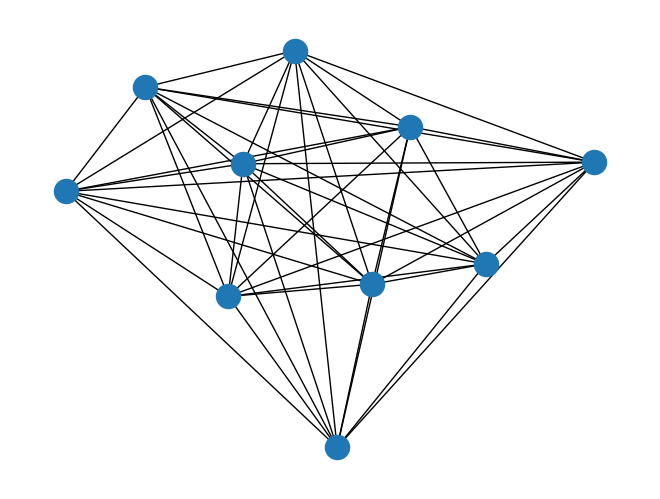

In [101]:
draw(Graph)

In [102]:
flow, flow_dict = maximum_flow(Graph, _s = source, _t = destination, capacity='weight')
print (flow) # total flow
print (flow_dict[0])

49
{1: 5, 2: 9, 3: 4, 4: 1, 5: 9, 6: 1, 7: 9, 8: 5, 9: 6}


maximum flow is equivalent to maximum path generation

In [103]:
from pulp import *
import pulp as pl

In [104]:
solver = pl.getSolver('CPLEX_CMD', timeLimit=10)
solver.path

'cplex.exe'

In [143]:
### TODO !!!!!!!!!!!!!!!!!
# Bcp de pertes de perf. Il faut le réimplémenter
# 
# 
# 
# 
def get_n_paths (Graph, source, destination, max_iter = 16):
    """ Get the max_iter paths of all_simple_paths generator: Graph: source --|> destination """
    list_ = []
    for index, path in enumerate (all_simple_paths(Graph, source, destination)):
        list_.append(path)
        if (index >= max_iter) :
            return (list_)
    return (list_)

In [106]:
# affichage de 8 chemins 
get_n_paths (Graph, 1, 2, max_iter = 3)

[[1, 0, 2], [1, 0, 3, 2], [1, 0, 3, 4, 2], [1, 0, 3, 4, 5, 2]]

In [121]:
# Etape 0 INIT THE MASTER PROBLEM

lpProb = pl.LpProblem("path generation", pl.LpMaximize)

paths = get_n_paths (Graph, source, destination, max_iter = n_edges)

lpProb += 0 # initiate the objective function to 0 (necessary line of code)

# pour chaque path ajouter une variable et ses coef. dans les contraintes
for index_path, path in enumerate (paths) :

    # add a var path
    prov = pl.LpVariable("X"+str(index_path), 0, None, pl.LpContinuous)
    lpProb.objective.addterm(prov, 1)
    
    # for each edge on the path, search the associated constraint (indexed by edge)
    for index in range(len(path)-1) :
        index_ctr = str((path[index], path[index + 1]))
        if index_ctr in lpProb.constraints:
            lpProb.constraints[index_ctr].addterm(prov, 1) # add term in constraint
        else:
            lpProb.constraints[index_ctr] = prov <= Graph.edges[(path[index], path[index + 1])]

solver = pl.CPLEX_PY()

result = lpProb.solve(solver)

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 28 rows and 51 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.06 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.06 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.06 ticks)
Cplex status= 101


In [125]:
# print results
for v in lpProb.variables():
    if v.varValue>0:
        print(v.name, "=", v.varValue)

X0 = 5.0
X1 = 9.0


In [139]:
lpProb

path_generation:
MAXIMIZE
1*X0 + 1*X1 + 1*X10 + 1*X11 + 1*X12 + 1*X13 + 1*X14 + 1*X15 + 1*X16 + 1*X17 + 1*X18 + 1*X19 + 1*X2 + 1*X20 + 1*X21 + 1*X22 + 1*X23 + 1*X24 + 1*X25 + 1*X26 + 1*X27 + 1*X28 + 1*X29 + 1*X3 + 1*X30 + 1*X31 + 1*X32 + 1*X33 + 1*X34 + 1*X35 + 1*X36 + 1*X37 + 1*X38 + 1*X39 + 1*X4 + 1*X40 + 1*X41 + 1*X42 + 1*X43 + 1*X44 + 1*X45 + 1*X46 + 1*X47 + 1*X48 + 1*X49 + 1*X5 + 1*X50 + 1*X6 + 1*X7 + 1*X8 + 1*X9 + 0
SUBJECT TO
(0, 1): X0 <= 5

(0, 2): X1 + X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X2
 + X20 + X21 + X22 + X23 + X24 + X25 + X26 + X27 + X28 + X29 + X3 + X30 + X31
 + X32 + X33 + X34 + X35 + X36 + X37 + X38 + X39 + X4 + X40 + X41 + X42 + X43
 + X44 + X45 + X46 + X47 + X48 + X49 + X5 + X50 + X6 + X7 + X8 + X9 <= 9

(2, 1): X1 <= 10

(2, 3): X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X2 + X20
 + X21 + X22 + X23 + X24 + X25 + X26 + X27 + X28 + X29 + X3 + X30 + X31 + X32
 + X33 + X34 + X35 + X36 + X37 + X38 + X39 + X4 + X40 + X41 + X42 +

In [141]:
def get_duals (lpPb):
    """ Get the dual variables from a problem Pulp """
    return [c.pi for _, c in list(lpPb.constraints.items())]

In [142]:
get_duals (lpProb)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
## Pulp ne permet pas de supprimer des variables ou contraintes.
## Idée: modifier les termes dans les contraintes sans changer de variable.
## Il faut donc se baser sur une table de hachage pour connaître la véritable variable
## associée... procédure longue à développer si on a le temps

## See: https://stackoverflow.com/questions/46469630/update-a-constraint-with-pulp

# add 10x3 in the 1st constraint
lpProb.constraints['_C1'].addterm(x3, 10)
print (lpProb.constraints)

# remove x3 term in the 1st constraint
lpProb.constraints['_C1'].pop(x3)
lpProb.constraints['_C2'].pop(x3)
print(lpProb.constraints)

# lpProb._variables.remove(x3)

print (lpProb._variables)
print (lpProb.objective)